# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 練習特徵重要性的寫作與觀察

# [作業重點]
- 仿造範例, 完成特徵重要性的計算, 並觀察對預測結果的影響 (In[3]~[5], Out[3]~[5]) 
- 仿造範例, 將兩個特徵重要性最高的特徵重組出新特徵, 並觀察對預測結果的影響 (In[8], Out[8]) 

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

data_path = './data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [3]:
# 隨機森林擬合後, 將結果依照重要性由高到低排序
estimator = RandomForestClassifier()
estimator.fit(df.values, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

Sex         0.250187
Ticket      0.159132
Name        0.138251
Fare        0.133233
Age         0.116502
Pclass      0.061599
Cabin       0.058497
SibSp       0.032393
Parch       0.029679
Embarked    0.020527
dtype: float64

## 先用隨機森林對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

# 作業1
* 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?

In [4]:
high_feature = feats[:5]
high_feature.index

Index(['Sex', 'Ticket', 'Name', 'Fare', 'Age'], dtype='object')

In [5]:
# 高重要性特徵 + 隨機森林
estimator = RandomForestClassifier() # create a new estimator
high_feature = feats[:5] # the top 5, threshold > 0.1
train_X = df[high_feature.index]
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8170359676103194

In [6]:
# 原始特徵 + 隨機森林
estimator = RandomForestClassifier() # create a new estimator
train_X = df
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8305316678174629

# 作業2
* 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?

In [7]:
feats.index

Index(['Sex', 'Ticket', 'Name', 'Fare', 'Age', 'Pclass', 'Cabin', 'SibSp',
       'Parch', 'Embarked'],
      dtype='object')

Text(0.5, 0, 'sex')

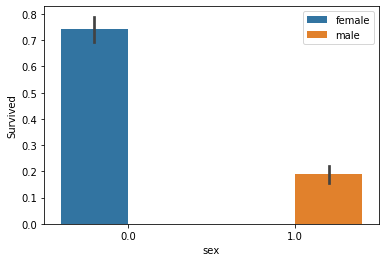

In [8]:
# 觀察重要特徵與目標的分布
# 第一名              
import seaborn as sns
import matplotlib.pyplot as plt

df['1st_char'] = df[feats.index[0]]

sns.barplot(x=df['1st_char'],y=train_Y,hue=df['1st_char'])
L = plt.legend()
L.get_texts()[0].set_text('female')
L.get_texts()[1].set_text('male')

plt.xlabel('sex')

In [9]:
df['2ed_char'] = df[feats.index[1]] # Ticket
df['2ed_char'] 

0      0.769118
1      0.876471
2      0.983824
3      0.072059
4      0.694118
         ...   
886    0.148529
887    0.020588
888    0.992647
889    0.011765
890    0.685294
Name: 2ed_char, Length: 891, dtype: float64

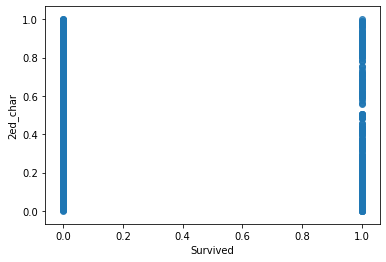

In [10]:
# 第二名      

df['2ed_char'] = df[feats.index[1]] # Ticket

sns.regplot(x=train_Y, y=df['2ed_char'], fit_reg=False)
plt.show()

In [11]:
# 製作新特徵看效果
"""
Your Code Here
"""
estimator = RandomForestClassifier() # create a new estimator
high_feature = feats[:5] # the top 5, threshold > 0.1
train_X = df[high_feature.index]
train_X['12'] = df['1st_char']+df['2ed_char']
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8271608813006089

In [12]:
'''
Use Select from Model to obtain the same result
'''

'\nUse Select from Model to obtain the same result\n'

In [13]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.15
sfm = SelectFromModel(RandomForestClassifier(), threshold=0.1)

# Train the selector
sfm.fit(df, train_Y)

# Print the names of the most important features
list_of_index = []
for index in sfm.get_support(indices=True):
    list_of_index.append(index)

In [14]:
# verify that the result is the same as sfm.transform
df[df.columns[list_of_index]].values

array([[0.12134831, 1.        , 0.76911765, 0.01415106, 1.        ,
        0.76911765],
       [0.21348315, 0.        , 0.87647059, 0.13913574, 0.        ,
        0.87647059],
       [0.39662921, 0.        , 0.98382353, 0.01546857, 0.        ,
        0.98382353],
       ...,
       [0.46404494, 0.        , 0.99264706, 0.04577135, 0.        ,
        0.99264706],
       [0.09101124, 1.        , 0.01176471, 0.0585561 , 1.        ,
        0.01176471],
       [0.24719101, 1.        , 0.68529412, 0.01512699, 1.        ,
        0.68529412]])

In [15]:
# verify that the result is the same as sfm.transform
train_X_imp = sfm.transform(df)

In [16]:
cross_val_score(estimator, train_X_imp, train_Y, cv=5).mean()

0.8305316678174627